# Задание
1) Выбрать хорошую (сложную) 3D модель как polygon mesh
2) Трансфигурировать модель в разные формы представления данных:
   1) воксильную,
   2) облако точек,
   3) функциональную,
   4) карту глубины.

In [1]:
import numpy as np
import trimesh

In [2]:
mesh = trimesh.load_mesh('../data/Skull/12140_Skull_v3_L2.obj')
mesh.show()

## Трансфигурация polygon mesh в voxel

In [3]:
voxel_mesh = mesh.voxelized(1)
voxel_mesh.show()

## Трансфигурация polygon mesh в point cloud

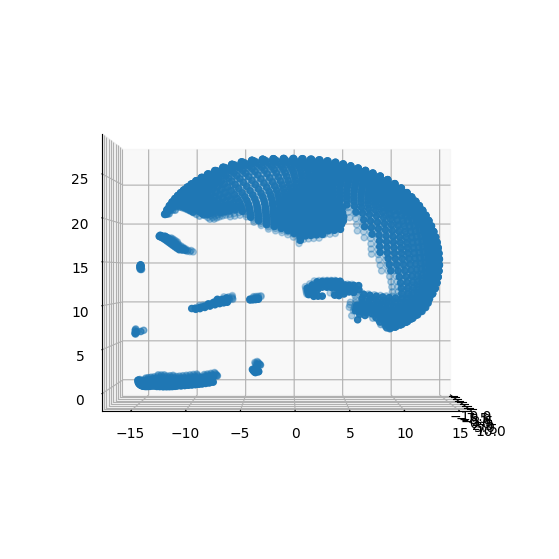

In [5]:
points_mesh = trimesh.convex.hull_points(mesh)
# Метод show от trimesh перестал работать, поэтому использую matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d');
x = points_mesh[:,0]
y = points_mesh[:,1]
z = points_mesh[:,2]
ax.scatter3D(x, y, z);
ax.view_init(0, 0)
plt.show()## Трансфигурация polygon mesh в твердотельную/функциональную модель (CAD models, functions)

## Трансфигурация polygon mesh в твердотельную/функциональную модель (CAD models, functions)

In [ ]:
from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface
center_mass = mesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])
for point in query_points:
    print(
        "SDF{0} = {1}".format(point[0] ,mesh_to_sdf(mesh,point)[0])
)

SDF[-1.82252159e-04  4.81246763e-01  1.63430028e+01] = -4.9048967361450195
SDF[3. 3. 3.] = 3.932310104370117


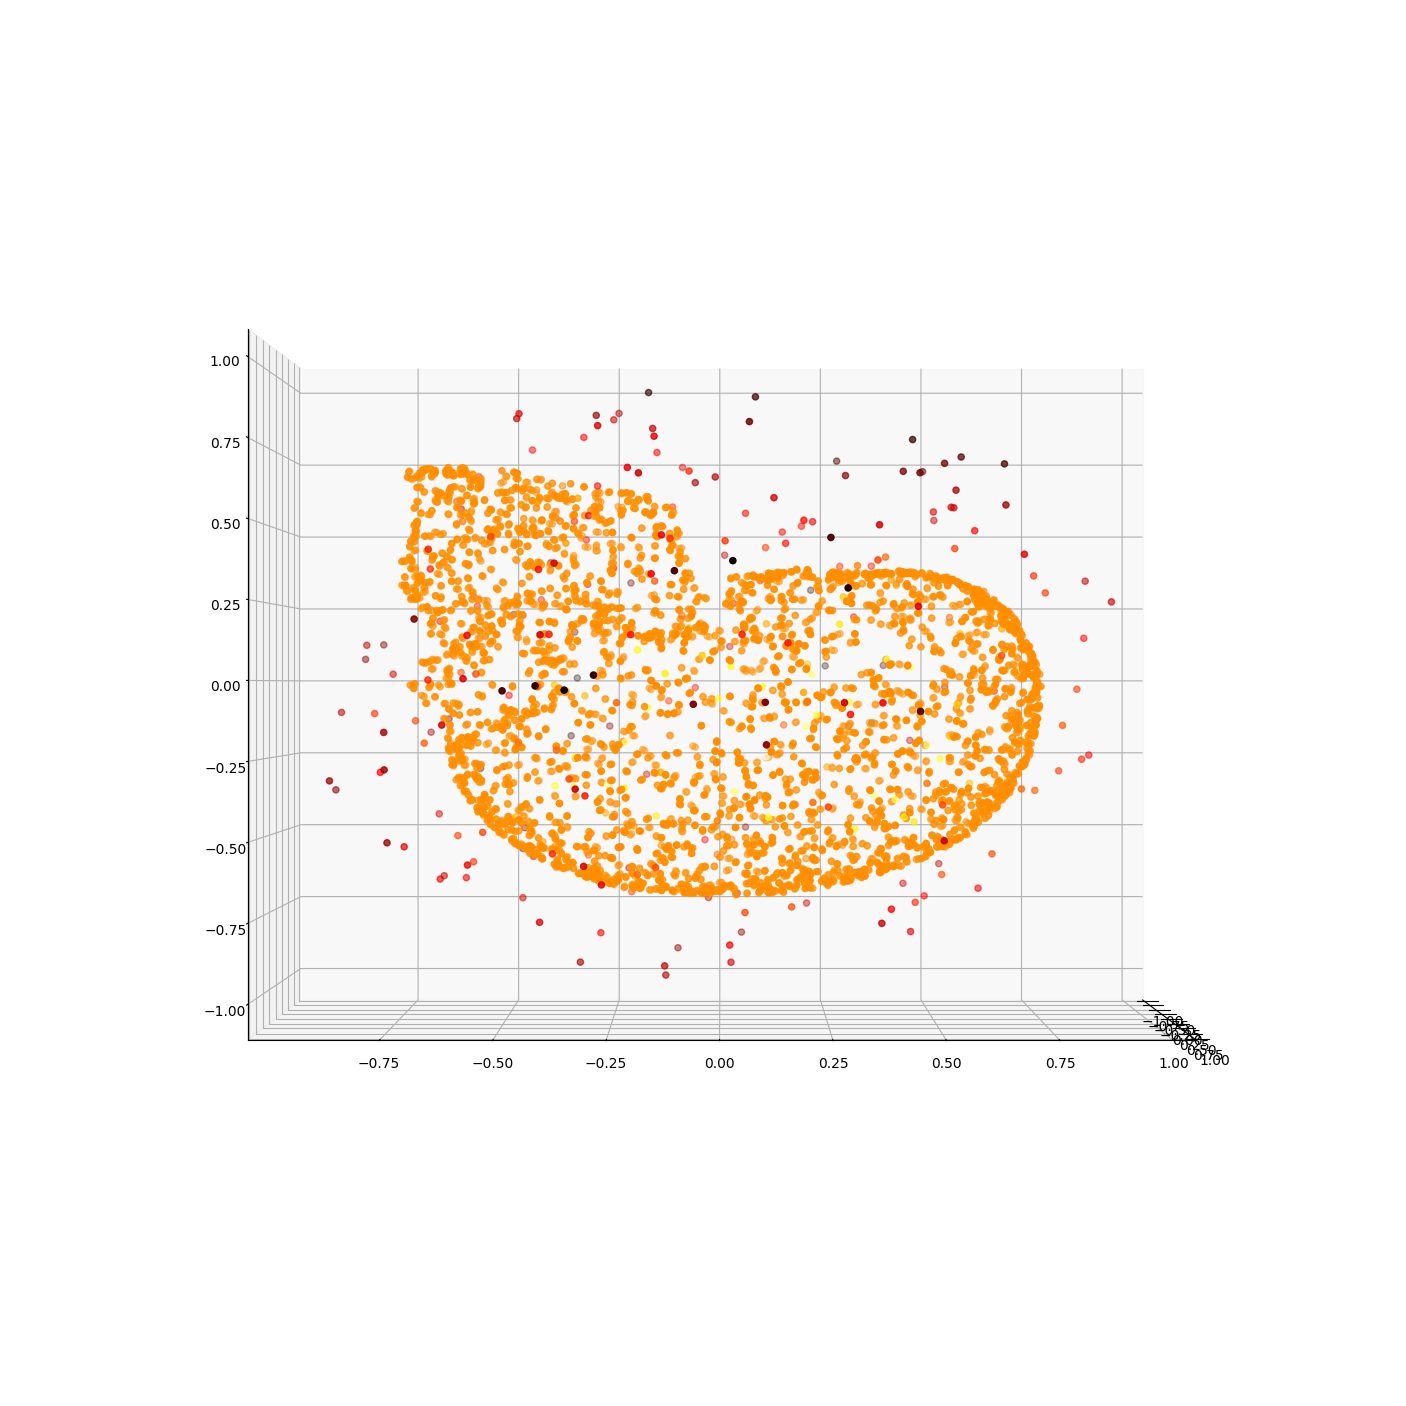

In [ ]:
points, sdf = sample_sdf_near_surface(mesh, number_of_points=5000)
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.view_init(0, 0)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")

## Трансфигурация polygon mesh в depth map

In [ ]:
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform,
    RasterizationSettings, BlendParams,
    MeshRenderer, MeshRasterizer, SoftPhongShader, SoftSilhouetteShader
)

from pytorch3d.io import load_obj
from pytorch3d.structures.meshes import Meshes
from pytorch3d.renderer.mesh.textures import TexturesAtlas
from torchvision import transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Получение вершин, граней и вспомогательной информации
verts, faces, aux = load_obj(f='12140_Skull_v3_L2.obj',
                             device=device,
                             load_textures=True,
                             create_texture_atlas=True,
                             texture_atlas_size=4,
                             texture_wrap=None)

# Создайте объект текстуры
atlas = aux.texture_atlas

# Инициализируйте сетку с вершинами, гранями и текстурами.
# Создан объект Meshes
obj_mesh = Meshes(verts=[verts],
                  faces=[faces.verts_idx],
                  textures=TexturesAtlas(atlas=[atlas]), )


print('We have {0} vertices and {1} faces.'.format(verts.shape[0], faces.verts_idx.shape[0]))

# Инициализируйте камеру с указанием расстояния до камеры, угла возвышения и угла азимута.
camera_distance = 60
camera_elv_angle =-90
camera_azi_angle = 180

R, T = look_at_view_transform(dist=camera_distance, elev=camera_elv_angle, azim=camera_azi_angle )
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256
output_im_size = 512
raster_settings = RasterizationSettings(image_size=output_im_size, blur_radius=0.0, faces_per_pixel=1,)

We have 40062 vertices and 80016 faces.


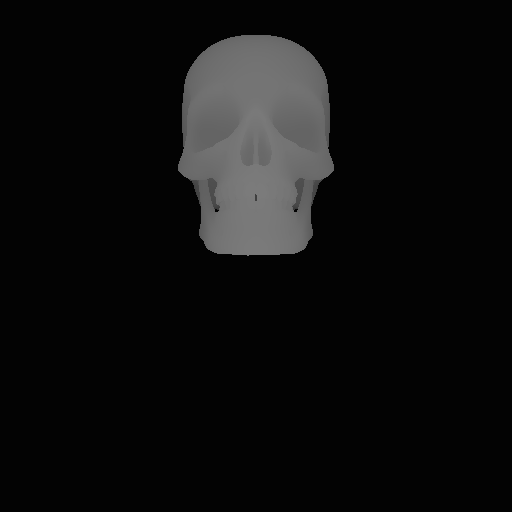

In [ ]:
# Инициализируем растеризатор с помощью класса MeshRasterizer
rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)

# Текстурированный шейдер Фонга интерполирует UV-координаты текстуры для
# каждую вершину и образцы изображения текстуры.
shader = SoftPhongShader(device=device, cameras=cameras)

# Создайте средство рендеринга сетки, объединив растеризатор и шейдер.
renderer = MeshRenderer(rasterizer, shader)

# вывод изображения с камеры
image = renderer(obj_mesh)
camera_view = (image[..., :3].squeeze() * 255).byte().cpu().numpy()
transforms.ToPILImage()(camera_view)

# выходное изображение глубины
fragments = rasterizer(obj_mesh)
depth_map = (fragments.zbuf.squeeze() * -3).byte().cpu().numpy()
transforms.ToPILImage()(depth_map)